In [1]:
from fastbook import search_images_ddg

def search_images(term, max_images=100):
    print(f'searching for {term}')
    return search_images_ddg(term, max_images)

/home/mark/miniconda3/envs/py10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from fastbook import search_images_ddg
results = search_images_ddg("happy man face photo")
results

(#200) ['https://thumbs.dreamstime.com/b/happy-man-smile-face-handsome-smiling-young-guy-human-facial-expressions-emotions-202968005.jpg','https://thumbs.dreamstime.com/z/happy-smiling-man-28078280.jpg','https://image.shutterstock.com/image-photo/happy-man-260nw-530856970.jpg','http://www.pngplay.com/wp-content/uploads/1/Happy-Men-Royalty-Free-PNG-Image.png','https://thumbs.dreamstime.com/b/happy-old-man-25013686.jpg','https://p1.pxfuel.com/preview/272/109/278/smiling-smile-happy-black-man-black-young.jpg','https://cdn.powerofpositivity.com/wp-content/uploads/2022/12/10-Things-Happy-Men-Do-Differently.jpg','https://dm0qx8t0i9gc9.cloudfront.net/thumbnails/video/rZJIMvhmliwmde8a6/videoblocks-old-man-with-two-thumbs-up-happy-senior-man-giving-two-thumbs-up-isolated-on-white-background-human-facial-expressions-and-body-langauge_rxg4bhzy_f_thumbnail-1080_01.png','https://www.pngplay.com/wp-content/uploads/1/Happy-Men-Free-Commercial-Use-PNG-Image.png','http://leapup.com/wp-content/uploads/2

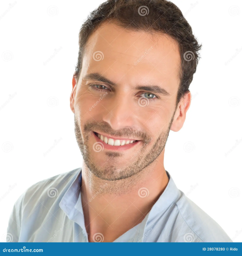

In [3]:
from fastdownload import download_url
dest = 'owp.jpg'
download_url(results[1], dest, show_progress=False)

import fastai.vision.all as fva
im = fva.Image.open(dest)
im.to_thumb(256,256)

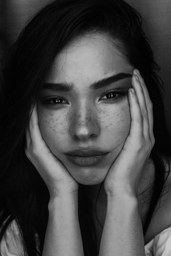

In [4]:
download_url(search_images_ddg('sad woman face photo', max_images=1)[0], 'fp.jpg', show_progress=False)
fva.Image.open('fp.jpg').to_thumb(256,256)

In [8]:
searches = {
    'happy': ['joyful', 
            # 'laughing', 'cheerful', 'smiling', 'euphoric'
             ],
    'sad': ['crying', 
            #'depressed', 'sorrowful', 'gloomy', 'melancholic'
           ],
    #'tired': ['sleepy', 
            #'exhausted', 'fatigued', 'weary', 'drained'
            # ],
    'scared': ['frightened', 
               #'terrified', 'panicked', 'fearful', 'alarmed'
              ],
    'angry': ['enraged', 
              #'furious', 'irritated', 'resentful', 'hostile'
             ],
    #'surprised': ['astonished', 'amazed', 'startled', 'bewildered', 'stunned'],
    #'disgusted': ['repulsed', 'nauseated', 'revolted', 'loathing', 'sickened'],
    #'content': ['satisfied', 'peaceful', 'relaxed', 'comfortable', 'at ease'],
    #'confused': ['perplexed', 'puzzled', 'baffled', 'bewildered', 'disoriented']
}

path = fva.Path('person_state')
from time import sleep

for emotion, additional_classifiers in searches.items():
    dest = (path/emotion)
    dest.mkdir(exist_ok=True, parents=True)
    for classifier in additional_classifiers:
        fva.download_images(dest, urls=search_images(f'{emotion} {classifier} man face photo'))
        sleep(2)  # Pause between searches to avoid over-loading server
        fva.download_images(dest, urls=search_images(f'{emotion} {classifier} woman face photo'))
        sleep(2)
    fva.resize_images(path/emotion, max_size=1024, dest=path/emotion)

searching for happy joyful man face photo
searching for happy joyful woman face photo
searching for sad crying man face photo
searching for sad crying woman face photo


/home/mark/miniconda3/envs/py10/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


searching for scared frightened man face photo
searching for scared frightened woman face photo
searching for angry enraged man face photo
searching for angry enraged woman face photo


In [9]:
import shutil
# shutil.rmtree(str(path))

In [12]:
failed = fva.verify_images(fva.get_image_files(path))
failed.map(fva.Path.unlink)
len(failed)

27

In [41]:
dls = fva.DataBlock(
    blocks=(fva.ImageBlock, fva.CategoryBlock), 
    get_items=fva.get_image_files, 
    splitter=fva.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=fva.parent_label,
    item_tfms=[fva.Resize(300, method='squish')]
).dataloaders(path, bs=12)

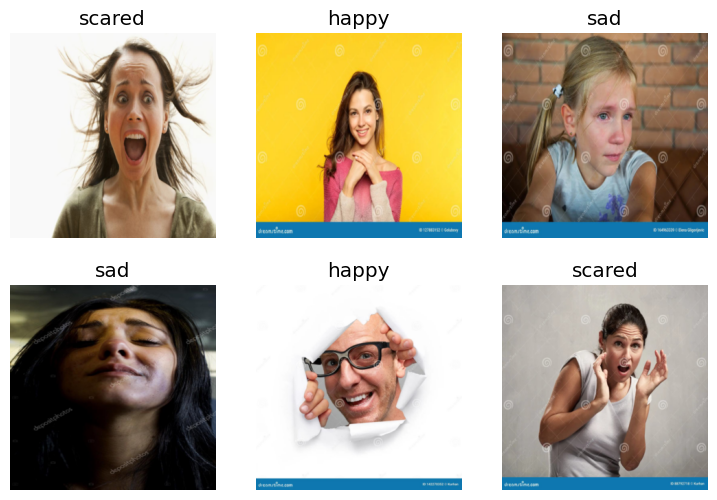

In [42]:
dls.show_batch(max_n=6)

In [44]:
learn = fva.vision_learner(dls, fva.resnet18, metrics=fva.error_rate)
learn.fine_tune(4)

/home/mark/miniconda3/envs/py10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mark/miniconda3/envs/py10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.034761,1.199366,0.356164,03:33


epoch,train_loss,valid_loss,error_rate,time
0,1.336668,1.064489,0.342466,04:16
1,0.945529,1.070469,0.349315,04:10


KeyboardInterrupt: 

In [45]:
state,pp,probs = learn.predict(fva.PILImage.create('fp.jpg'))
print(f'This is a: {state} person.');
print(f'Probability that the person is {state}: {probs[pp]:.4f}')
probs

This is a: sad person.
Probability that the person is sad: 0.9998


tensor([1.6315e-05, 3.9105e-05, 9.9982e-01, 1.2169e-04])

In [46]:
learn.dls.vocab

['angry', 'happy', 'sad', 'scared']

In [47]:
list(zip(learn.dls.vocab, probs))

[('angry', tensor(1.6315e-05)),
 ('happy', tensor(3.9105e-05)),
 ('sad', tensor(0.9998)),
 ('scared', tensor(0.0001))]

In [27]:
import fastbook as fb
uploader = fb.widgets.FileUpload()
# uploader

In [ ]:
#img = fva.PILImage.create(uploader.data[0])
#state,pp,probs = learn.predict(img)
#print(f"This is a: {state}.")
#print(f"Probability this is a {state}: {probs[pp]:.4f}")
#probs

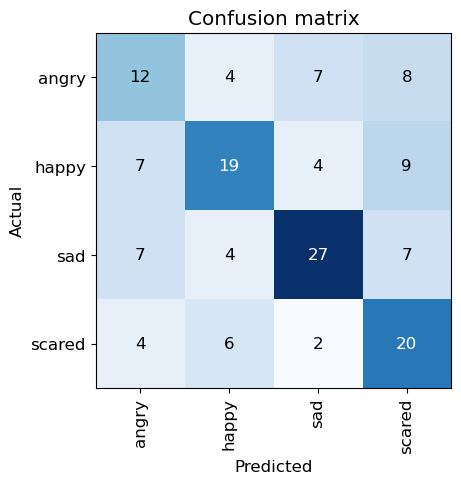

In [28]:
interp = fb.ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

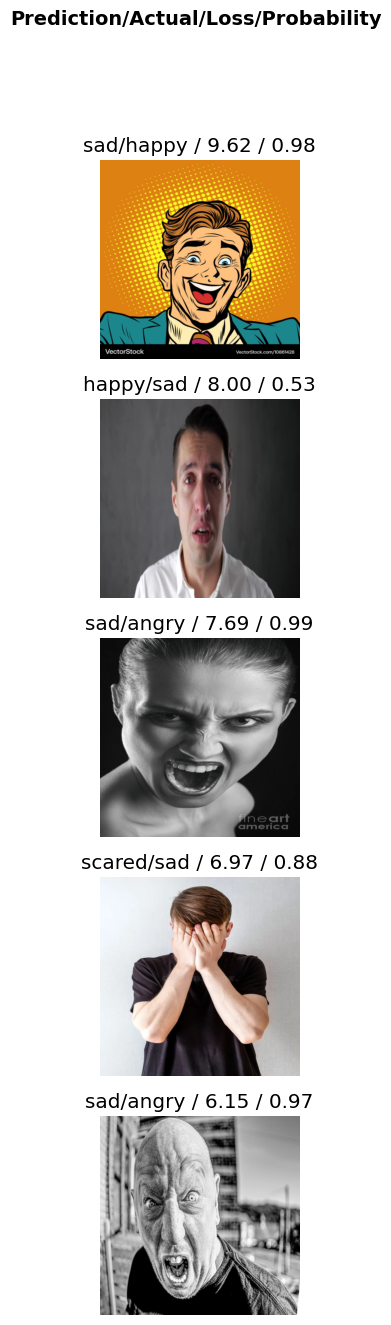

In [29]:
interp.plot_top_losses(5, nrows=5)

In [48]:
import fastai.vision.widgets as fvw
cleaner = fvw.ImageClassifierCleaner(learn, max_n=100)
cleaner

In [52]:
cleaner.delete()

(#4) [0,3,5,6]

In [50]:
cleaner.change()

(#1) [(1, 'sad')]

In [34]:
cleaner.fns

(#30) [Path('person_state/angry/beb8f949-1d95-483b-a5bc-b1525e1a7a60.jpg'),Path('person_state/angry/971d1cee-fbbc-480f-8404-79c218932e29.jpg'),Path('person_state/angry/d173ed65-4bba-47f9-a20c-2d22346e2947.jpg'),Path('person_state/angry/e50ca2d2-1362-40a2-bc2c-a6c8c4cff241.jpg'),Path('person_state/angry/6c26c903-40bb-4530-8c16-e9c7dc6caa03.png'),Path('person_state/angry/fe79b166-c5ca-4153-b6ea-dde43203f86f.jpg'),Path('person_state/angry/810a9cc9-61b4-42fc-b5af-519d596509d4.jpg'),Path('person_state/angry/92a3f476-7d72-4a23-a0e7-4d55f1eebcc9.jpg'),Path('person_state/angry/bc757e08-b98d-4797-8168-c632538c1747.jpg'),Path('person_state/angry/b085b7e6-5519-44d0-a193-4d8a8fe22809.jpg')...]

In [51]:
for idx in cleaner.delete():
    if cleaner.fns[idx].exists():
        cleaner.fns[idx].unlink()
for idx, cat in cleaner.change():
    if cleaner.fns[idx].exists():
        shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export()